In [1]:
import sys
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
sys.path.append("../")
import h5py
from MLRF.Networks import DSCNN, BasicCNN


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# -------------------------------------------------------------------
# Weight Initialization Function
# -------------------------------------------------------------------
def init_weights(m):
    """
    Initialize convolutional and linear layers using Kaiming normal initialization.
    """
    if isinstance(m, (nn.Conv1d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# -------------------------------------------------------------------
# Training Function with Gradient Clipping
# -------------------------------------------------------------------
def train(dataloader, model, loss_fn, optimizer, scaler):
    model.train()
    total_loss = 0
    batch_losses = []
    
    pbar = tqdm(dataloader, desc="Training", unit="batch", leave=False)
    for sample, label in pbar:
        sample = sample.to(device, non_blocking=True)
        label = label.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast("cuda"):
            pred = model(sample)
            loss = loss_fn(pred, label)
        
        scaler.scale(loss).backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        scaler.step(optimizer)
        scaler.update()
        
        batch_loss = loss.detach().cpu().item()
        total_loss += batch_loss * sample.size(0)
        batch_losses.append(batch_loss)
        pbar.set_postfix(loss=batch_loss)
    
    return total_loss / len(dataloader.dataset), batch_losses

# -------------------------------------------------------------------
# Testing Function
# -------------------------------------------------------------------
def test(dataloader, model, loss_fn):
    model.eval()
    total_loss = 0
    correct = 0
    batch_accuracies = []
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Testing", unit="batch", leave=False)
        for sample, label in pbar:
            sample = sample.to(device, non_blocking=True)
            label = label.to(device, non_blocking=True)
            
            with torch.amp.autocast("cuda"):
                output = model(sample)
                loss = loss_fn(output, label)
                total_loss += loss.item() * sample.size(0)
                
            pred = output.argmax(dim=1)
            correct += pred.eq(label).sum().item()
            batch_acc = 100 * pred.eq(label).float().mean().item()
            batch_accuracies.append(batch_acc)
            pbar.set_postfix(acc=batch_acc)
    
    avg_loss = total_loss / len(dataloader.dataset)
    overall_acc = 100 * correct / len(dataloader.dataset)
    return avg_loss, overall_acc, batch_accuracies

class PSDDataset(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
        with h5py.File(file_path, 'r') as f:
            self.keys = list(f.keys())
        
    def __len__(self):
        return len(self.keys)
    
    def __getitem__(self, idx):
        with h5py.File(self.file_path, 'r') as f:
            key = self.keys[idx]
            data = torch.tensor(f[key][:], dtype=torch.float32)
            # Label: 0 if key starts with 'wifi', otherwise 1 (assumes BT keys don't start with 'wifi')
            label = 0 if key.startswith('wifi') else 1
        return data.unsqueeze(0), label  # Add channel dimension

In [3]:

# Hyperparameters
config = {
    'batch_size': 512,
    'epochs': 3,
    'lr': 1e-4,
    'patience': 5,
    'model_path': 'best_model.pth'
}

# Dataset and DataLoader with optimized settings
train_dataset = PSDDataset("/home/kush/projects/MULT-25-607-ML-for-RF-Sprectrum-sensing/src/model/data/finished/train_abs.hdf5")
test_dataset = PSDDataset("/home/kush/projects/MULT-25-607-ML-for-RF-Sprectrum-sensing/src/model/data/finished/test_abs.hdf5")

train_loader = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config['batch_size']*2,
    num_workers=8,
    pin_memory=True
)

# Model setup
model = BasicCNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=1e-4)
scaler = torch.amp.GradScaler('cuda')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)

best_acc = 0
patience_counter = 0

for epoch in range(config['epochs']):
    train_loss, _ = train(train_loader, model, loss_fn, optimizer, scaler)
    test_loss, test_acc, _ = test(test_loader, model, loss_fn)
    scheduler.step(test_acc)
    
    # Save best model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), config['model_path'])
        patience_counter = 0
    else:
        patience_counter += 1
        
    # Early stopping
    if patience_counter >= config['patience']:
        print(f"Early stopping at epoch {epoch}")
        break
        
    print(f"Epoch {epoch+1}/{config['epochs']}: "
            f"Train Loss: {train_loss:.4f}, "
            f"Test Loss: {test_loss:.4f}, "
            f"Test Acc: {test_acc:.2f}%")

print(f"Best accuracy: {best_acc:.2f}%")

Training:   0%|          | 0/351 [00:00<?, ?batch/s]

Testing:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 1/3: Train Loss: nan, Test Loss: nan, Test Acc: 44.85%


Training:   0%|          | 0/351 [00:00<?, ?batch/s]

Testing:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 2/3: Train Loss: nan, Test Loss: nan, Test Acc: 44.85%


Training:   0%|          | 0/351 [00:00<?, ?batch/s]

Testing:   0%|          | 0/46 [00:00<?, ?batch/s]

Epoch 3/3: Train Loss: nan, Test Loss: nan, Test Acc: 44.85%
Best accuracy: 44.85%


NameError: name 'train_losses' is not defined

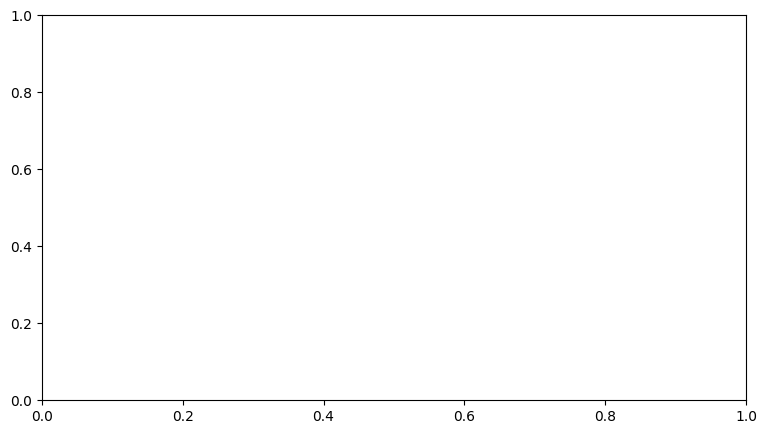

In [4]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="train")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.025))
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))

plt.subplot(1, 2, 2)
plt.plot(accuracies, label="accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=1)
ymin, ymax = min(accuracies), max(accuracies)
if ymax > ymin:
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator((ymax - ymin)/4))
else:
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.25))
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))

plt.tight_layout()
plt.show()